### 1st Virtual Methods Seminar: Methods of Computational Social Science
## Introduction to Social Network Science with Python
# Community Detection - Exercise 1.4 (Solutions)
Instructors: Haiko Lietz & Lisette Espín Noboa

Date: September 24, 2020
## Packages

In [1]:
import sys
libs_path = '../libs/'
sys.path.append(libs_path)
import compsoc as cs

In [2]:
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd

In [3]:
import community as louvain

## Introduction
In this exercise, we will again look at the Copenhagen Networks Study collection to study community detection. Load the dataset using the `copenhagen_collection()` function:

In [4]:
users, genders, bluetooth, calls, sms, facebook_friends = cs.copenhagen_collection(path='../../data/copenhagen/')

We use the same networks as in the `32_cohesion_exercise notebook`. For the `bluetooth` data, we sum up the signal strengths and remove signals with zero strength:

In [5]:
bluetooth = bluetooth[['user_id_from', 'user_id_to', 'strength']].groupby(['user_id_from', 'user_id_to']).sum().reset_index()
bluetooth = bluetooth[bluetooth['strength'] > 0]

The `facebook_friends` dataframe needs a unit weight so the dataframe meets the data format expectations:

In [6]:
facebook_friends['weight'] = 1

## Exercise 1
Study this **bluetooth** graph:

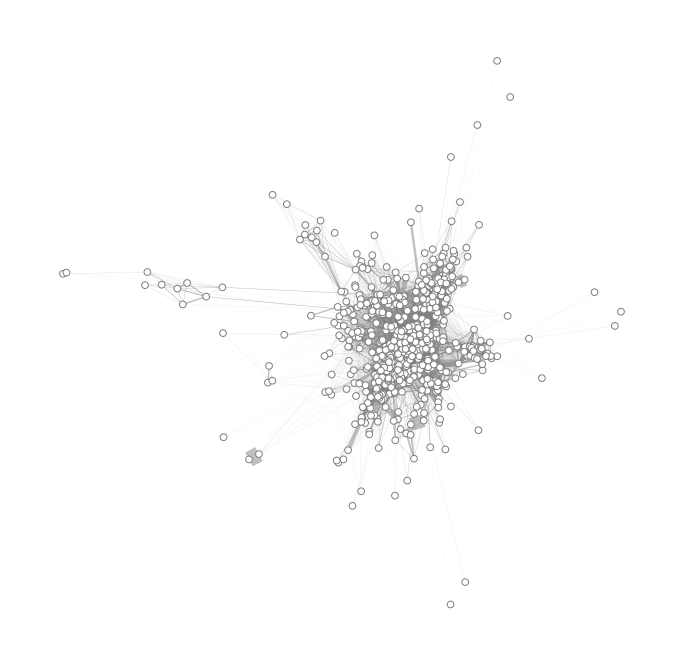

In [7]:
# construct graph
G = cs.construct_graph(
    directed=False, 
    multiplex=False, 
    graph_name='co_proximity', 
    node_list=users, 
    edge_list=bluetooth[bluetooth['strength'] > 500]
)

# extract the largest connected component and create a layout
G = G.subgraph(max(nx.connected_components(G), key=len))
vp_node_pos_bluetooth = nx.spring_layout(G, seed=0)

# draw graph
cs.draw_graph(
    G, 
    node_pos=vp_node_pos_bluetooth, 
    edge_width_factor=.0001, 
    edge_transparency=.5, 
    figsize='large'
)

Explore how to call the different community detection methods and how they behave. Check the effect of edge weights and the resolution parameter if available.
## Solution 1
### Louvain communities

In [8]:
louvain_partition = louvain.best_partition(G, resolution=2)
len(set(louvain_partition.values())) # with resolution=5
                                     # there are 3 communities without weight='weight'
                                     # and 4 with weight='weight'

10

In [9]:
# the layout improved after a few more iterations
vp_node_pos_bluetooth = nx.spring_layout(G, seed=0, iterations=100)

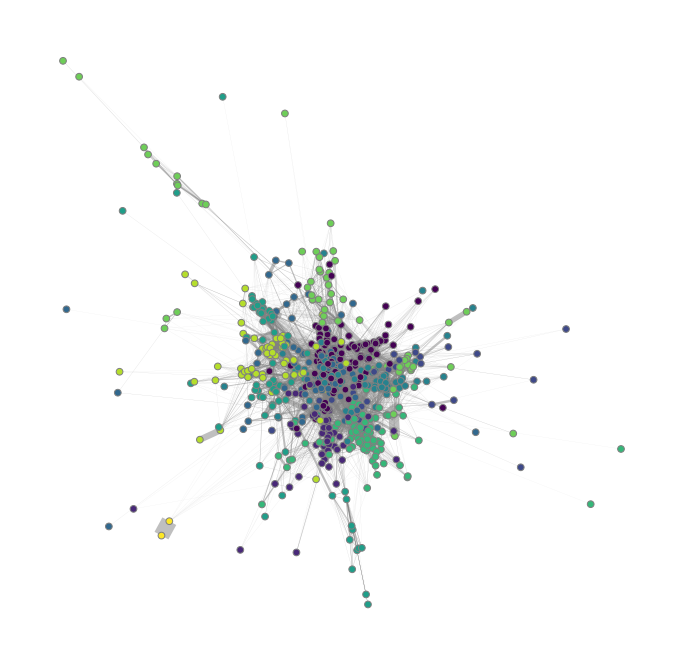

In [10]:
cs.draw_graph(
    G, 
    node_pos=vp_node_pos_bluetooth, 
    node_color=louvain_partition, 
    edge_width_factor=.0001, 
    edge_transparency=.5, 
    figsize='large'
)

### Modularity-based communities

In [11]:
def get_partition(communities):
    '''
    communities: list of lists
    '''
    communities_dict = {}
    for community in range(0, len(communities)):
        for node in range(0, len(communities[community])):
            communities_dict[communities[community][node]] = community
    communities_dict = dict(sorted(communities_dict.items()))
    return communities_dict

In [12]:
greedy_modularity_communities = nx.algorithms.community.greedy_modularity_communities(G, weight='weight')
len(greedy_modularity_communities) # there is 1 community without weight='weight'
                                   # and 653 with weight='weight'

653

In [13]:
greedy_modularity_communities = [list(cluster) for cluster in greedy_modularity_communities]

In [14]:
# modularity is 0, like that of a random graph
nx.algorithms.community.quality.modularity(G, greedy_modularity_communities)

-0.0021122660402246736

In [15]:
greedy_modularity_partition = get_partition(greedy_modularity_communities)

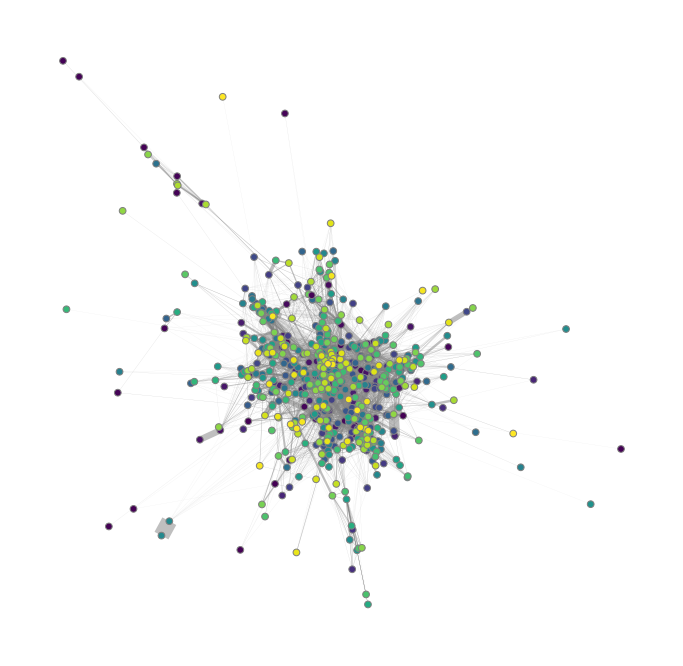

In [16]:
# this plot shows 653 colors. they are just not distinguishable
# matplotlib, the library used for drawing, choses similar colors for the 653 communities
cs.draw_graph(
    G, 
    node_pos=vp_node_pos_bluetooth, 
    node_color=greedy_modularity_partition, 
    edge_width_factor=.0001, 
    edge_transparency=.5, 
    figsize='large'
)

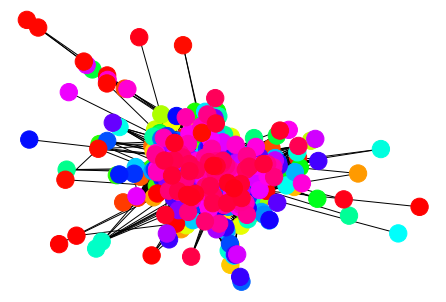

In [17]:
# in nx.draw() we can specify a different (cyclic) colormap.
# I should add this option to the cs.draw_graph() function
nx.draw(
    G, 
    pos=vp_node_pos_bluetooth, 
    node_color=list(greedy_modularity_partition.values()), 
    cmap='hsv'
)

### Label propagation

In [18]:
label_propagation_communities = nx.algorithms.community.label_propagation_communities(G)

In [19]:
label_propagation_communities = [list(cluster) for cluster in label_propagation_communities]

In [20]:
nx.algorithms.community.quality.modularity(G, label_propagation_communities)

0.3955840325719652

In [21]:
label_propagation_partition = get_partition(label_propagation_communities)

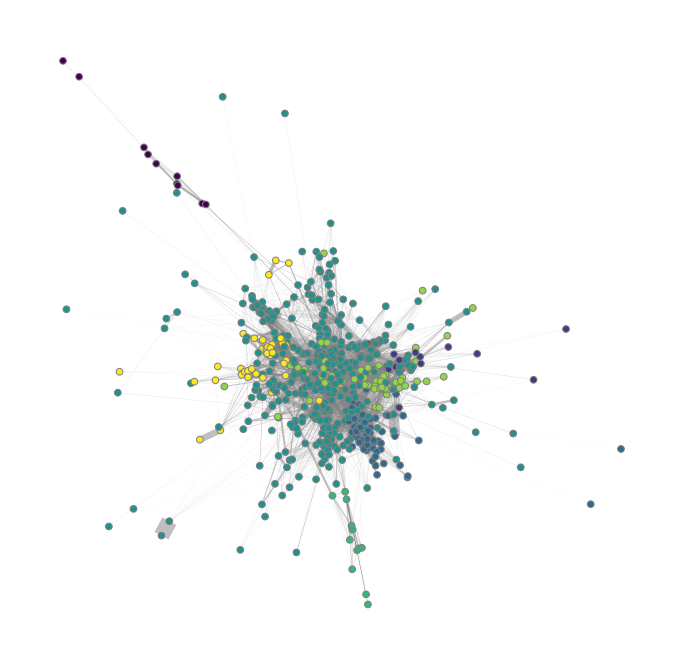

In [22]:
cs.draw_graph(
    G, 
    node_pos=vp_node_pos_bluetooth, 
    node_color=label_propagation_partition, 
    edge_width_factor=.0001, 
    edge_transparency=.5, 
    figsize='large'
)

### Partitions via betweenness centrality measure

In [23]:
def get_nested_partitions(communities_generator, levels):
    '''
    communities_generator: generator
    '''
    nested_partitions = []
    nested_communities = []
    for level in range(levels):
        communities = next(communities_generator)
        communities = sorted(map(sorted, communities))
        partition = get_partition(communities)
        nested_partitions.append(partition)
        nested_communities.append(communities)
    return nested_partitions, nested_communities

In [24]:
girvan_newman_communities = nx.algorithms.community.centrality.girvan_newman(G)

In [25]:
## if this throws an error, it may be because the generator object has already been called.
## in this case rerun the cell above
#
#this function is too slow, I need to change it
#
#levels = 20
#
#girvan_newman_nested_partitions, girvan_newman_nested_communities = get_nested_partitions(girvan_newman_communities, levels)

In [26]:
#level = 3
#
#cs.draw_graph(
#    G, 
#    node_pos=vp_node_pos_bluetooth, 
#    node_color=girvan_newman_nested_partitions[level], 
#    edge_width_factor=.0001, 
#    edge_transparency=.5, 
#    figsize='large'
#)

## Exercise 2
Study the **facebook-friends** graph:

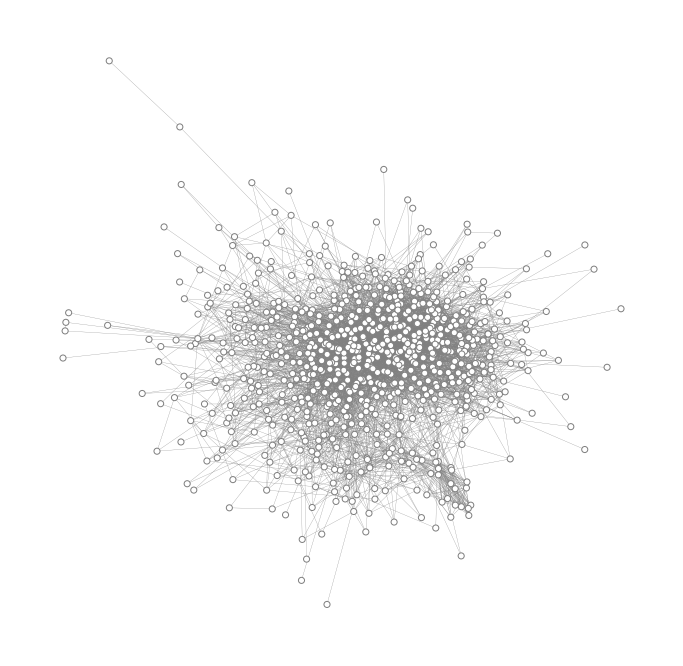

In [27]:
# construct graph
H = cs.construct_graph(
    directed=False, 
    multiplex=False, 
    graph_name='facebook_friends', 
    node_list=users, 
    edge_list=facebook_friends, 
    node_label='user'
)

# remove self-loops, extract the largest connected component, and create a layout
H.remove_edges_from(nx.selfloop_edges(H))
H = H.subgraph(max(nx.connected_components(H), key=len))
vp_node_pos_facebook_friends = nx.spring_layout(H, seed=0)

# draw graph
cs.draw_graph(
    H, 
    node_pos=vp_node_pos_facebook_friends, 
    edge_width_factor=.25, 
    figsize='large'
)

We have already seen that this graph has a marked core/periphery structure. How does Louvain community detection behave on such a graph?
## Solution 2

In [28]:
louvain_partition = louvain.best_partition(H, resolution=1)
len(set(louvain_partition.values()))

13

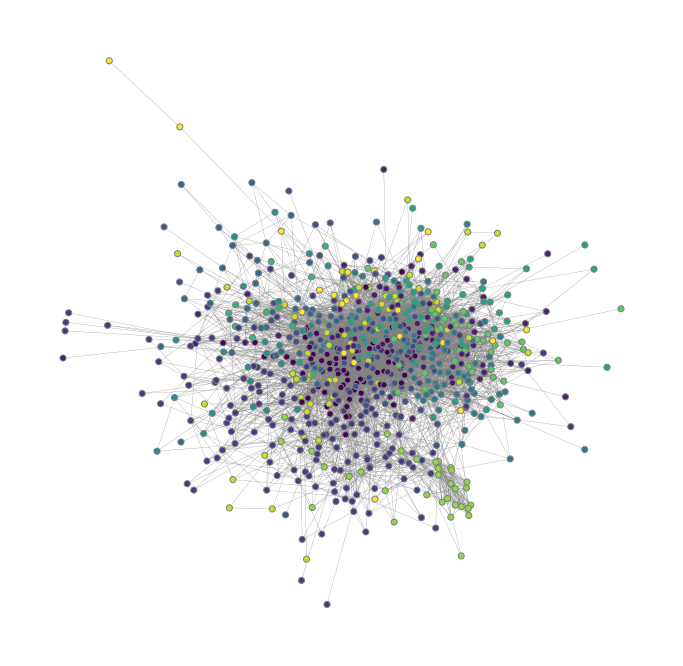

In [29]:
# with resolution=3, it detects the two "obvious" communities
# with resolution=1, it finds partitions that are hard to evaluate by eyeballing because
#     the layout algorithm also influences interpretation

cs.draw_graph(
    H, 
    node_pos=vp_node_pos_facebook_friends, 
    node_color=louvain_partition, 
    edge_width_factor=.25, 
    figsize='large'
)